In [1]:
!uv pip install pandas matplotlib

Audited 2 packages in 22ms


In [2]:
import pandas as pd
df = pd.read_json("./traffic_report.jsonl", lines=True)

In [3]:
df.head()

,query_time,origin,destination,clear_duration_mins,traffic_duration_mins
0,2025-10-04 22:28:23.993181,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.666667
1,2025-10-04 22:30:02.670300,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.833333
2,2025-10-04 22:35:02.525222,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,14.066667
3,2025-10-04 22:40:02.322524,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,14.033333
4,2025-10-04 22:45:02.199550,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.500000


<Axes: xlabel='query_time'>

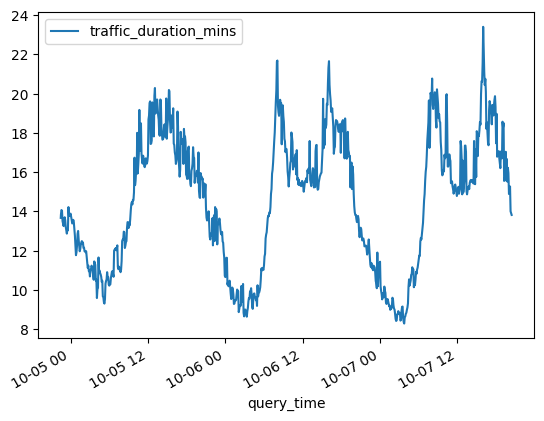

In [4]:
df.plot("query_time", "traffic_duration_mins")

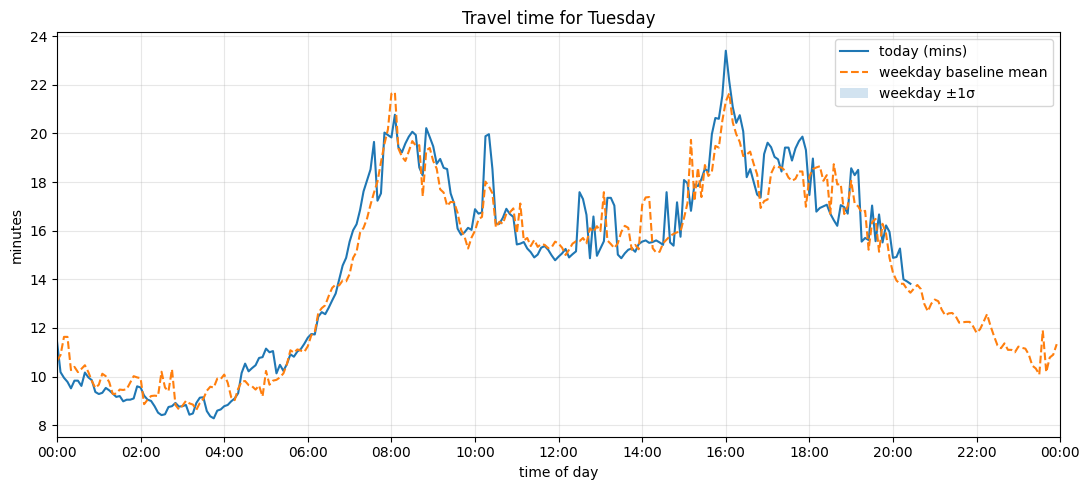

Potential anomalies: 0


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

# --- Parse & features ---
df["query_time"] = pd.to_datetime(df["query_time"])
df["date"] = df["query_time"].dt.date
df["dow"] = df["query_time"].dt.dayofweek  # 0=Mon ... 6=Sun
df["time_bucket"] = df["query_time"].dt.floor("5min")
df["time_of_day"] = df["time_bucket"].dt.time

today = df["date"].max()
dow_name = pd.to_datetime(today).strftime("%A")

# Build a fixed midnight→midnight x-axis for today (5-min buckets)
midnight = pd.Timestamp(today)
end_of_day = midnight + pd.Timedelta(days=1)
timeline = pd.date_range(midnight, end_of_day, freq="5min", inclusive="left")

# --- Build WEEKDAY baseline (Mon–Fri), from all past data (exclude today) ---
weekday_mask = df["dow"] < 5
history_mask = df["date"] < today  # avoid peeking at today
baseline_df = (
    df[weekday_mask & history_mask]
    .groupby("time_of_day")["traffic_duration_mins"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)
baseline_df["std"] = baseline_df["std"].fillna(0.0)

# Expand baseline to the full day timeline by matching on time-of-day
baseline_map = baseline_df.set_index("time_of_day")
tod_series = pd.Series([ts.time() for ts in timeline], index=timeline, name="time_of_day")
baseline_mean = tod_series.map(baseline_map["mean"])
baseline_std = tod_series.map(baseline_map["std"]).fillna(0.0)

# --- Today’s series, aligned to 5-min buckets ---
today_df = (
    df[df["date"] == today]
    .assign(bucket=lambda x: x["query_time"].dt.floor("5min"))
    .sort_values("query_time")
    .copy()
)

# If there are multiple samples in a bucket, average them
today_series = (
    today_df.groupby("bucket")["traffic_duration_mins"]
    .mean()
    .reindex(timeline)  # align to full-day axis (NaN where no data yet)
)

# --- Plot: baseline runs midnight→midnight; today shows only available data ---
plt.figure(figsize=(11, 5))

# Today line (will naturally stop at the latest timestamp we have)
plt.plot(timeline, today_series, label="today (mins)")

# Baseline mean line (full-day)
plt.plot(timeline, baseline_mean, linestyle="--", label="weekday baseline mean")

# Shaded ±1σ band across the full day (gaps where baseline missing)
lower = baseline_mean - baseline_std
upper = baseline_mean + baseline_std
plt.fill_between(timeline, lower, upper, alpha=0.2, label="weekday ±1σ")

# --- Formatting: x-axis is strictly today's time, midnight→midnight, time labels only ---
plt.xlim(midnight, end_of_day)
plt.gca().xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 2)))  # every 2 hours
plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))

plt.title(f"Travel time for {dow_name}")
plt.xlabel("time of day")
plt.ylabel("minutes")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- (Optional) quick anomaly table for your console: only on timestamps where we have data today ---
merged_current = pd.DataFrame({
    "query_time": timeline,
    "traffic_duration_mins": today_series,
    "mean": baseline_mean,
    "std": baseline_std.replace(0, np.nan),
}).dropna(subset=["traffic_duration_mins", "mean"])  # need both to assess deviation

merged_current["pct_dev"] = 100 * (merged_current["traffic_duration_mins"] - merged_current["mean"]) / merged_current["mean"]
merged_current["z"] = (merged_current["traffic_duration_mins"] - merged_current["mean"]) / merged_current["std"]

anoms = merged_current[(merged_current["pct_dev"] > 30) & (merged_current["z"] > 2)]
print(f"Potential anomalies: {len(anoms)}")
if not anoms.empty:
    display(merged_current.loc[anoms.index, ["query_time","traffic_duration_mins","mean","pct_dev","z"]].head(10))
